In [27]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
from cellpose import utils, io, models, plot
from scipy.spatial import distance as dist
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio.v2 as imageio
import copy
from PIL import Image
from fil_finder import FilFinder2D
from shapely.geometry import Polygon
from skimage.util import invert
from skimage.morphology import skeletonize
from cv2 import imwrite
from tools import prune2
from scipy.interpolate import splprep
from scipy.interpolate import splev
from IPython.core.display import HTML
import random

date = "08-10-2015"
my_data = "../data/" + date + "/Height/"
my_pfe = "../data/" + date + "/Peak_Force_Error/"
my_apm = "../data/" + date + "/Amplitude/"
my_sti = "../data/" + date + "/Stiffness/"
segments_path = "../cellpose_outputs/" + date + "/Height/"
cell_path = "Individual_cells/"
diam = 30
flow = 0.8

## Load Current Metadata

In [28]:
datasets = pd.read_csv('Dataset Analysis.csv')

In [29]:
datasets

Date (name)  # of masks (start)  # of masks (end)  max # masks  min # masks  \
0  05-10-2015                18.1              15.6           27            8   
1  06-10-2015                11.0              17.6           21            7   
2  07-10-2015                18.7              29.8           37           16   
3  08-10-2015                65.7              89.5          100           38   
4  30-03-2015                 1.6               5.6            7            1   

   false positives (frac)  false negatives (frac)  diameter  flow rate  
0                0.645534                0.183333        60        0.8  
1                0.630248                0.369444        40        0.8  
2                0.444382                0.223389        30        0.8  
3                0.758575                0.312997        30        0.8  
4                0.551587                0.263889        60        0.8

## Run Cellpose

In [30]:
# Load up a list of input files from our example data.
files = os.listdir(my_data)
for fichier in files[:]:
    if not(fichier.endswith(".png")):
        files.remove(fichier)
        
# Sort files by timepoint.
files.sort(key = tools.natural_keys)      

# Create a list that contains the full path to each of our image files. 
save_names = [segments_path + file for file in files]
file_names = [my_data + file for file in files]

## Not necessary, so long as diameter and flow threshold are known

In [31]:
# Specify that the cytoplasm Cellpose model for the segmentation. 
model = models.Cellpose(gpu=True, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
channels = [0,0]

# Loop over all of our image files and run Cellpose on each of them. 
for filename, savename in zip(file_names, save_names):
    img = io.imread(filename)
    masks, flows, styles,diams = model.eval(img, diameter = diam, channels=channels, flow_threshold = flow)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, savename, channels)

    #save results as png
    io.save_to_png(img, masks, flows, savename)

In [32]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

In [33]:
# Initialize lists.
outl_temp = []
height_img_list = []
stiff_img_list = []
pfe_img_list = [] 

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    
    # Remove small masks from the data
    #dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 1500)
    
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original image.
    image = dat["img"]
    height_img_list.append(image)
    
    # If it exists, read in the png with the stiffness and PFE.
    if os.path.exists(my_sti + str(time) + "_Stiffness.png") == True:
        stiff_img_list.append(imageio.imread(my_sti + str(time) + "_Stiffness.png"))
    else:
        stiff_img_list.append(np.nan)
        
    if os.path.exists(my_pfe + str(time) + "_PFE.png") == True:
        pfe_img_list.append(imageio.imread(my_pfe + str(time) + "_PFE.png"))
    else:
        pfe_img_list.append(np.nan)

In [34]:
# The image dictionary contains the complete images for all of the image types. 
img_dict = {
    "Height": height_img_list,
    "Stiffness": stiff_img_list,
    "PFE": pfe_img_list
    }
# The metadata dictionary will hold all of the data we want to save into our final table.
metadata_dict = {}

# The individual cell dictionary will save information for each individual cell such as the outline, skeleton, cropped image, etc. 
ind_cell_dict = {}

# The structural dictionary will hold information on the timepoint of each image, the cell IDs for each cell in each image,
# and the outlines and bounding boxes for each cell in each image.
structural_dict = {
    "Time": time_list
    }

In [35]:
# Initialize a list of boxes
boxes_temp = []
box_img = copy.deepcopy(height_img_list)

# Fill lists with the coordinates of bounding boxes for each cell outline.
for outl, img in zip(outl_temp, box_img):
    boxes = tools.get_boxes(outl)
    boxes_temp.append(boxes)
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)

In [36]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_list = []
boxes_list = []
centers_list = []

# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_temp, box_img, outl_temp):
    # update our centroid tracker using the computed set of bounding box rectangles
    objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    boxes_new = []
    centers = []
    # loop over the tracked objects
    for (objectID, info) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (info[1][0] - 10, info[1][1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (info[1][0], info[1][1]), 4, (0, 255, 0), -1)
        # append the object ID and its associated outline and center to the lists. 
        IDs.append(objectID)
        outl_new.append(info[2])
        centers.append(info[1])
        boxes_new.append(info[0])
    boxes_list.append(boxes_new)
    IDs_list.append(IDs)
    outl_list.append(outl_new)
    centers_list.append(centers)

In [37]:
# Add our new lists to the proper dictionaries. 
structural_dict["IDs"] = IDs_list
structural_dict["outlines"] = outl_list
structural_dict["bounding_boxes"] = boxes_list

metadata_dict["centroids"] = centers_list

# Destroy the temporary lists to get some more space. 
boxes_temp.clear()
outl_temp.clear()

## Find the number of masks as a timeseries

In [38]:
num_of_masks=[len(out_set) for out_set in structural_dict['outlines']]

## Manually estimate the number of masks which cover a single, complete cell

In [39]:
def sam_plot ():
    '''
    plots a random sample of outlines from cellpose
    ----
    Returns
    
    A list of the number of masks in each of these images
    '''
    global sam_counts
    sam_counts = []
    sam_size = max(len(num_of_masks)//10, 5)
    sam=random.sample(range(len(num_of_masks)),sam_size)
    
    fig,axs=plt.subplots(2,sam_size,figsize=(10*sam_size,20))
    counts=[]
    for i in range (sam_size):
        ind = sam[i]
        dat = np.load(segments_path + segmented[ind], allow_pickle=True).item()
        maski= dat['masks']
        img = img_dict['Height'][ind]
        outlines=plot.outline_view(img,maski,color=[0,255,0])
        axs[0,i].imshow(img)
        axs[1,i].imshow(outlines)
        sam_counts.append(num_of_masks[ind])

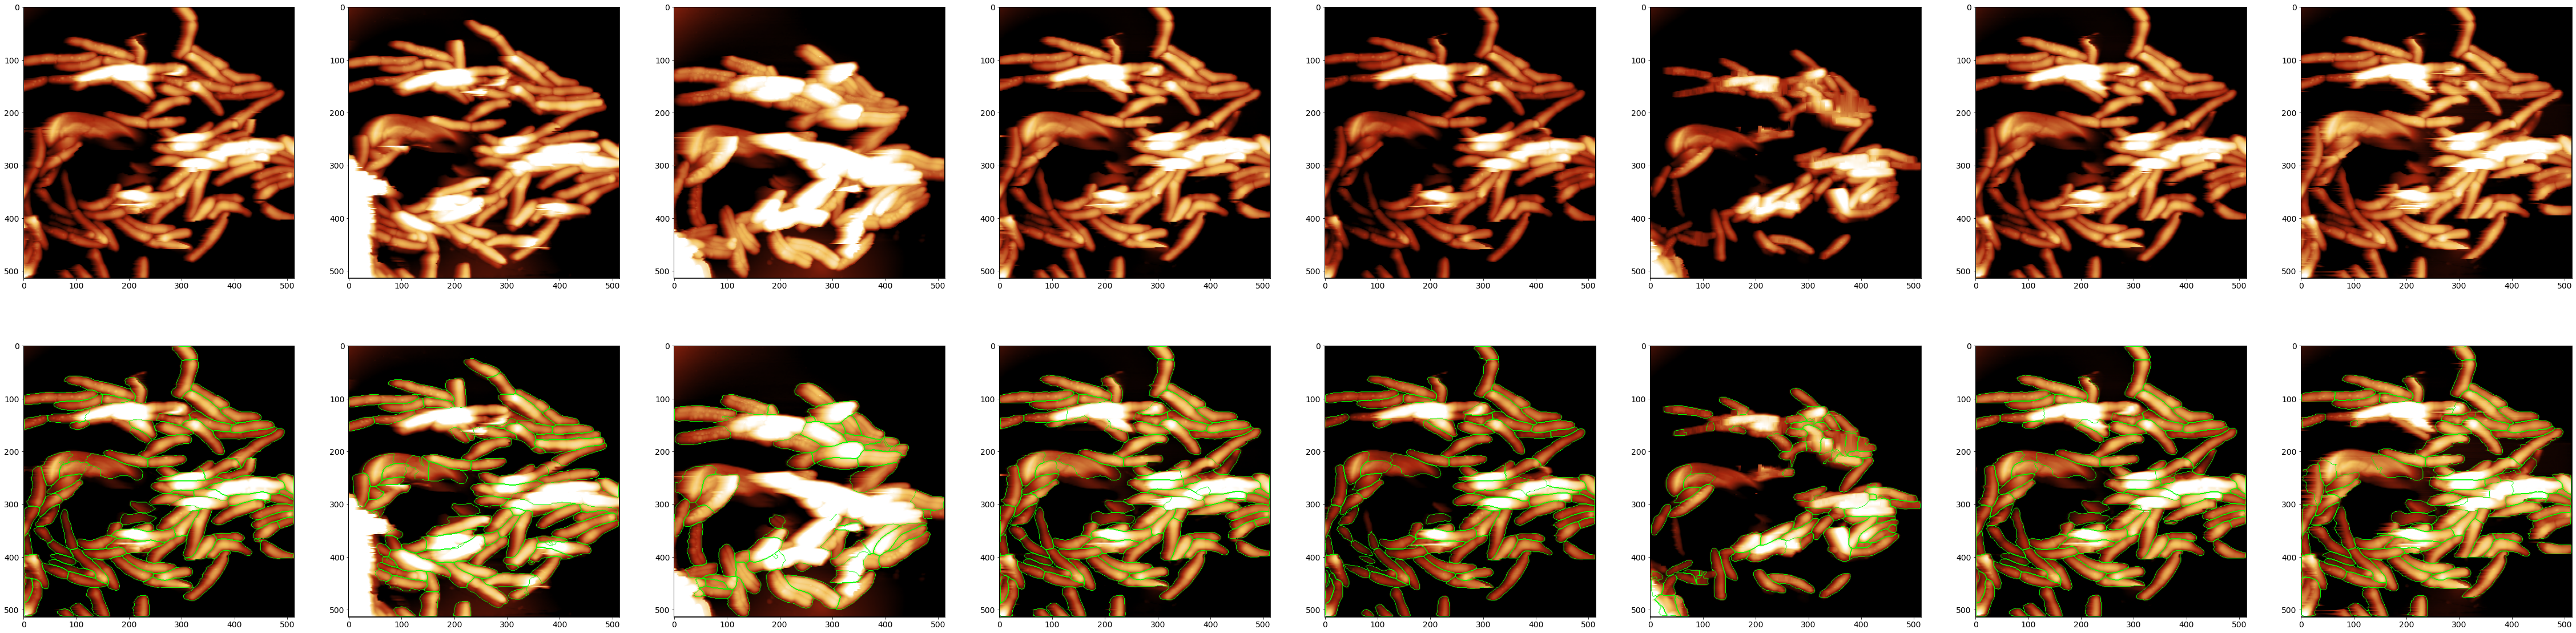

In [40]:
sam_plot()

In [15]:
cells_in_masks=[] #number of masks correctly identifying a cell in each image
human_counts = [] # number of cells counted manually in the image

## Aggregate and save metadata

In [16]:
pos = 1-np.average([cells_in_masks[i]/sam_counts[i] for i in range (len(cells_in_masks))])
neg = 1-np.average([cells_in_masks[i]/human_counts[i] for i in range (len(cells_in_masks))])

In [17]:
data = pd.DataFrame([[date,sum(num_of_masks[:10])/len(num_of_masks[:10]),sum(num_of_masks[-10:])/len(num_of_masks[-10:]), max(num_of_masks),min(num_of_masks),pos,neg,diam,flow]],
                    columns=datasets.columns.tolist())

In [18]:
data = pd.concat([datasets,data])

In [19]:
data.to_csv('Dataset Analysis.csv',index=False)

In [20]:
data

Date (name)  # of masks (start)  # of masks (end)  max # masks  min # masks  \
0  05-10-2015                18.1              15.6           27            8   
1  06-10-2015                11.0              17.6           21            7   
2  07-10-2015                18.7              29.8           37           16   
3  08-10-2015                65.7              89.5          100           38   
0  30-03-2015                 1.6               5.6            7            1   

   false positives (frac)  false negatives (frac)  diameter  flow rate  
0                0.645534                0.183333        60        0.8  
1                0.630248                0.369444        40        0.8  
2                0.444382                0.223389        30        0.8  
3                0.758575                0.312997        30        0.8  
0                0.551587                0.263889        60        0.8